# Homework 5

### Overview
This homework assignment is divided into two parts: 1) Prediction of HOLC labels and 2) geodemographic clustering 

### Deliverables: 
1. Pandas notebook with outputs

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 

# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## There is no need to import libraries more than once!

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. Predicting HOLC grades
In this exercise, you are going to explore some historical Census data and understand its relationships with the Home Owners' Loan Corporation (HOLC) risk maps. These maps were made by the HOLC in the late 1930s-early 1940s for the HOLC to make assessments of neighborhood risk after the HOLC bailed out underwater borrowers who were unable to pay their mortgage loans as a consequence of the Great Depression. Mortgage risk was assessed with all residential neighborhoods being given an A, B, C, or D grade: 

- A = "best"
- B = "still desirable"
- C = "definitely declining"
- D = "hazardous"

While these maps have become known as the "redlining maps" note that the agency didn't use these maps to make decisions on who/where should get loans. They actually made these maps after loan activities were already over! However, these maps do provide an interesting window into how the real estate industry viewed different neighborhoods, during a period when redlining (by savings and loan banks, the Federal Housing Administration, amongst others) occurred. In 1968, Congress signed the Fair Housing Act of 1968, also known as Title VIII of the Civil Rights Act of 1968, that formally made discrimination by race, sex, color, religion, disability, family status, and national origin illegal. This is considered by many scholars to be the legal end of discriminatory redlining practices (although they still occur, in various ways, to today). 

There are three time periods to consider when we're thinking about the "impacts" of the redlining: 
- The pre-redlining period: for now, we'll say that is 1930 and any 1930-1940 trends. 
- The redlining period: 1940 - 1970
- The post-redlining period: 1980 - present

The overall aim of this study is to understand whether we think there is a relationship between HOLC grades and present-day outcomes in racial outcomes and neighborhood outcomes such as education or median income. The underlying mechanism here might be that HOLC grades led to disinvestment in neighborhoods, which leads to poor conditions, the concentration of poverty, and low opportunities for people who live in that neighborhood. This leads us to test two scenarios: 

1. Can we use neighborhood conditions to predict historical HOLC grades during the period of redlining? 
2. Similarly, if we think that grades were also determined by neighborhood socioeconomic and demographic conditions, can we use these to predict HOLC grades? 

## 1.1 Load in the data
The folder `holc_data` can be downloaded [here](https://www.dropbox.com/scl/fo/efovuq4dg9mmrwhtnvak6/AHew7g8n0jqkuxPGpU3lZBQ?rlkey=g7371rzvg8m2duq86hg3jc6nk&dl=0).

In [2]:
### This is a version of the data with all the years as separate columns
holc_data = gpd.read_file('https://www.dropbox.com/scl/fi/i017f3g4juwtf6rmpijcq/holc_data_1930_2016.geojson?rlkey=scxpkogx5hcj1r1rvdwg297g8&dl=1',driver='GeoJSON')

### This is a version of the data with the years concatenated
holc_data_v2 = []
for y in ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']: 
    df = gpd.read_file(f'holc_data/holc_overlay_{y}')
    df['year'] = y
    holc_data_v2.append(df)

holc_data_v2= pd.concat(holc_data_v2)[['city','holc_grade','population','white_perc','colored_pe','hispanic_p','other_perc','college_pe','median_inc','unemployed','geometry','year']]

holc_data_v2 = holc_data_v2.rename(columns={'colored_pe':'black_perc','hispanic_p':'hispanic_perc','college_pe':'college_perc','unemployed':'unemployed_perc'})

In [3]:
holc_data.columns

Index(['city', 'holc_grade', 'holc_id', 'population_2016', 'white_perc_2016',
       'black_perc_2016', 'hispanic_perc_2016', 'other_perc_2016',
       'college_perc_2016', 'median_inc_2016', 'unemployed_perc_2016',
       'population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       'white_perc_1980', 'black_perc_1980', 'hispanic_perc_1980',
       'other_perc_1980', 'college_perc_1980', 'median_inc_1980',
       'unemployed_perc_1980', 'population_1990', 'white_perc_1

In [4]:
pd.set_option('display.max_rows', None)

print(holc_data.city)

#there seems to be multiple entries with same city name (probably different districts)

pd.reset_option('display.max_rows')

0                                  Akron
1                                 Albany
2                                Altoona
3                               Bay City
4                              Cambridge
5                             Bergen Co.
6                            Springfield
7                             Bergen Co.
8                                 Canton
9                            Springfield
10                               Chicago
11                               Chicago
12                               Chicago
13                             Cleveland
14                             Cleveland
15                            Fort Wayne
16                              Columbus
17                              Columbus
18                              Columbus
19                              Columbus
20                              Columbus
21                              Columbus
22                                Dallas
23                               Detroit
24              

In [5]:
#confirming that there are different tracts for the same city

#uncomment to plot
#holc_data[holc_data['city']=='Columbus'].explore()

## 1.2 Data cleaning and exploration (10 pts)
In addition to your .describe() descriptive statistics, in the following cells, create charts and/or maps that will tell us the following: 
- Define your characteristics of interest 
- What are the historical trends for each characteristic? 

Make sure to describe (Also, do all Census characteristics exist for all years??)

Based on holc_data's columns, the characteristics of interest are demographics (total population, white percentage, black percentage, and hispanic percentage), median income, employment rate and college education percentage. Information is not available in all years, but only in 1930-2010 in 10 year intervals, and also in 2016. However, the earlier years have less data. For example, holc_data only contains population, white percentage and black percentage for 1930 and 1940, with no information on income, education, or employment.

First, remove rows where the HOLC grade is 'E' in both datasets.

In [6]:
## insert your code here
holc_data = holc_data[holc_data["holc_grade"]!='E']
holc_data_v2 = holc_data_v2[holc_data_v2["holc_grade"]!='E']

Next, create charts where 'year' is on the x-axis and the socioeconomic/demographic information is on the y axis. 

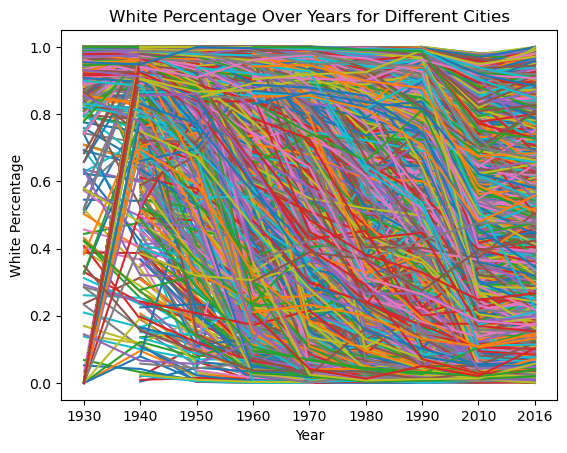

In [7]:
### Plotting white percentage for all rows in holc_data
years = ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']
df = holc_data

rows, columns = df.shape

for i in range(rows):

  city_data = df.iloc[i]
  city_income = [city_data[f'white_perc_{year}'] for year in years]

  plt.plot(years, city_income, label=city_data.city)

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
#plt.legend()
plt.show()

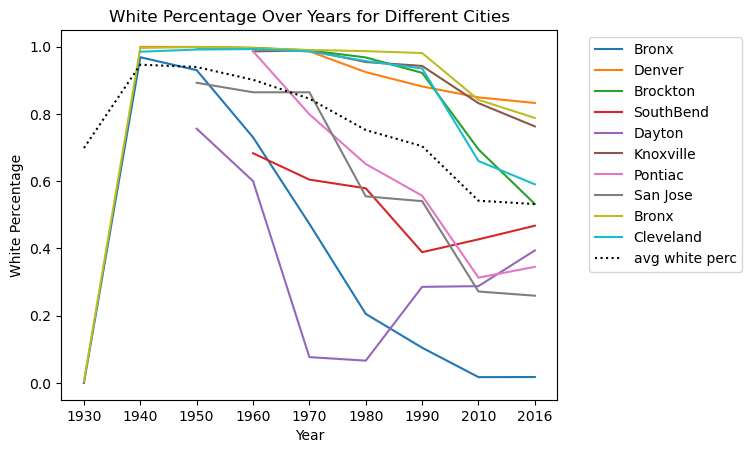

In [8]:
##this is way too dense, so I randomly sample 10 places to plot
#I also plot the avg values so there's a sense of all data

metric_name = "white_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_white_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_white_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg white perc")

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

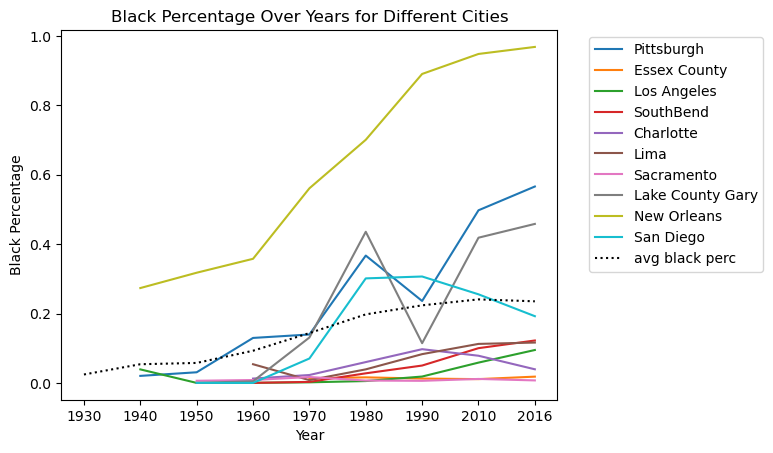

In [9]:
##black percentage
metric_name = "black_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_black_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_black_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg black perc")

plt.xlabel('Year')
plt.ylabel('Black Percentage')
plt.title('Black Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

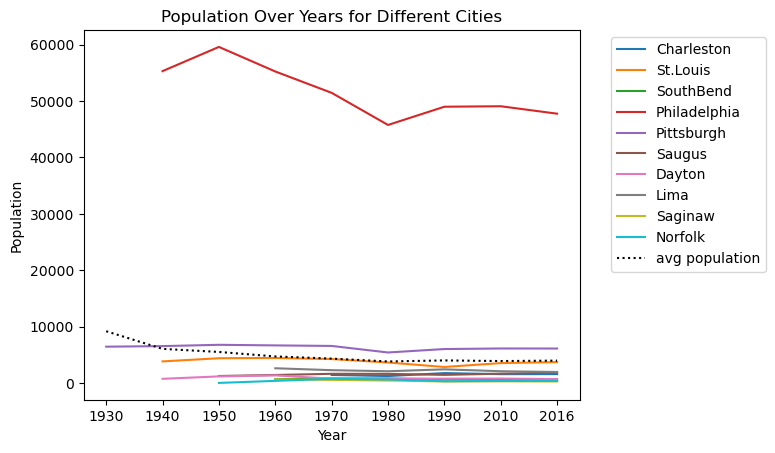

In [10]:
##population
metric_name = "population_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_population = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_population, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg population")

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

 From the data above I think there's a general decrease a white percentage (probably because cities became more diverse due to immigration), an increase in black percentage. However, although the trend line for population shows that population decreased, I don't think it's because the cities with data in 1930-50 were relatively large and gradually the data included more mid-sized and small cities. (1930-1950 data each has >2800 missing values out of 8394 entries (>33%).) So I think population either stayed relatively the same or increased.

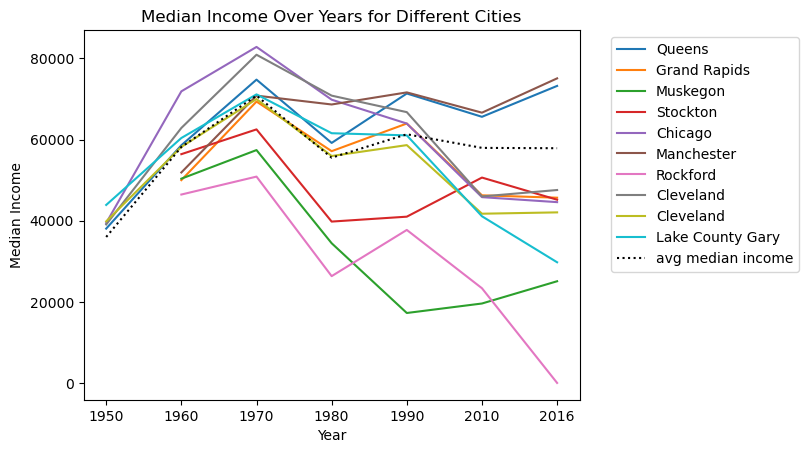

In [11]:
#there's no income data for 1930/40, so shortening year list
short_years = ['1950','1960','1970','1980','1990','2010', '2016']

metric_name = "median_inc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_income = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_income, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg median income")

plt.xlabel('Year')
plt.ylabel('Median Income')
plt.title('Median Income Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Median income trends vary, although they increased up until 1970. It decreased slightly afterwards, then remained largely the same.

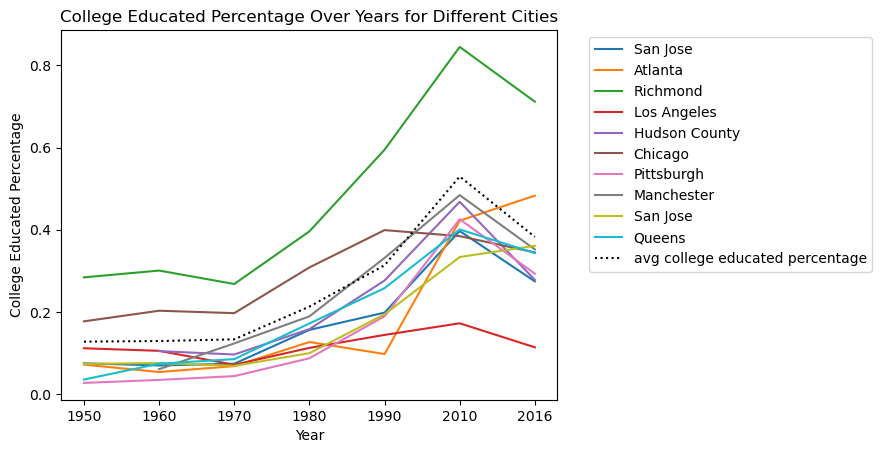

In [12]:
#college education
short_years = ['1950','1960','1970','1980','1990','2010', '2016']

metric_name = "college_perc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_data = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_data, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg college educated percentage")

plt.xlabel('Year')
plt.ylabel('College Educated Percentage')
plt.title('College Educated Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


College education percentage rose steadily until 2010, but declined slightly after 2016.

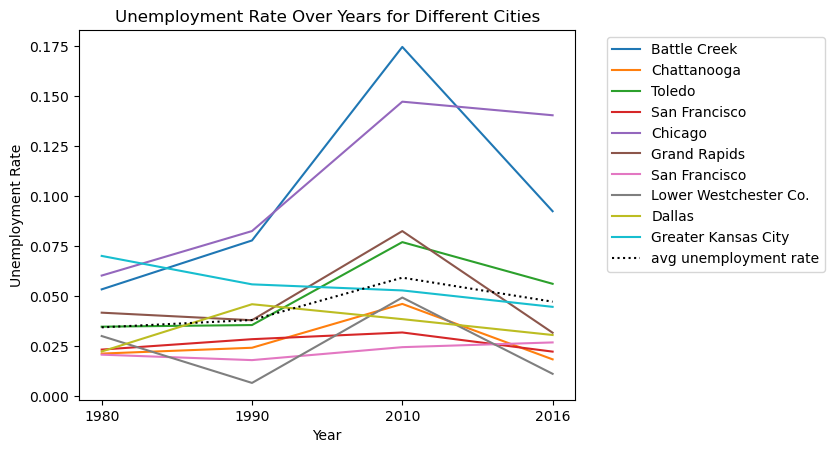

In [13]:
#unemployment data only starts in 1980
short_years = ['1980','1990','2010', '2016']

metric_name = "unemployed_perc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_data = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_data, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg unemployment rate")

plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Unemployment Rate Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


It seems like unemployment trends vary greatly. Although on average they increased (especially after 2008, but there also was a decrease from 2010 to 2016).

## 1.3 Predicting HOLC grade using socioeconomic and demographic data during redlining (10 pts)
We believe that since HOLC grades are determinative of demographic and socioeconomic characteristics, we can back out grades by using some of these characteristics. Let's use some of these to predict HOLC grades. Here you will use the `holc_data` dataset. 

First, create `X` and `y` arrays contains our features and targets. 

In [14]:
## insert your code here.
#here's all the data columns we are interested in
data_cols = [
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       ]

X = holc_data[data_cols]
y = holc_data['holc_grade']

Do we have any `NaN`s? Our ML models will not accept missing data. 

In [15]:
##yes, there are NaNs in the X values (not in the Y values) 
print(f"total NaNs in X: {X.isna().sum().sum()}")
print(f"total NaNs in y: {y.isna().sum()}")

total NaNs in X: 35125
total NaNs in y: 0


In order to assure we do not have any `NaNs` in our data, which , we'll replace all of our `NaN`s with the median of the column

In [16]:
## insert your code here. 
X =X.fillna(X.mean())

We'll also want standardize our data as well.

In [17]:
## insert your code here. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [18]:
#trying one-hot encoding, decreased accuracy :(
from sklearn.preprocessing import OneHotEncoder

# Example labels represented as strings
y_test = np.array(y)

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform OneHotEncoder to encode labels
y_encoded = one_hot_encoder.fit_transform(y_test.reshape(-1, 1))

y_encoded

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Now let's split our data into a train and test set. 

In [19]:
## insert your code here. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.33, random_state=42) #random state set for consistency

Using a `RandomForestClassifier` model, let's train our model to predict `y_train` on the input data `X_train` 

In [20]:
## insert your code here. 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

How well did our model do? Show the accuracy, F1, AUC ROC, log loss

In [21]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Assuming multi-class classification
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest (OvR) strategy for multi-class AUC-ROC
logloss = log_loss(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Log Loss:", logloss)

Accuracy: 0.5312161674485745
F1 Score: 0.5055193710579191
AUC-ROC Score: 0.786484062456678
Log Loss: 1.0695219173975887


The performance was not so great, since the accuracy is only 52.8%.
AUC-ROC score is close to 1, which means the model has good discriminatory power between positive and negative instances. The lower log loss is better, so log loss of 1.12 shows a lot of uncertainty in the predictions.

Now try a different model and let's see if our results were better. 

In [22]:
## insert your code here.
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_pred_proba = gb.predict_proba(X_test)

Show the classification scores again for this new model. 

In [23]:
## insert your code here.
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Assuming multi-class classification
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest (OvR) strategy for multi-class AUC-ROC
logloss = log_loss(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Log Loss:", logloss)

Accuracy: 0.5297726452544208
F1 Score: 0.5000499949789825
AUC-ROC Score: 0.7927713823949486
Log Loss: 0.9965888962636114


Since the scores weren't so different, let's go back to the RF Classifier model and tune its hyperparamters, so we can look at feature importances later. Please explain what you chose to tune. 

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 9],
              'min_samples_split': [2, 5, 10, 20]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)

In [25]:
grid.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_split': [2, 5, 10, 20]},
             verbose=1)

In [26]:
sorted(grid.cv_results_.keys())
grid.best_params_

{'max_depth': 9, 'min_samples_split': 5}

In [27]:
## I chose to tune the train/test split (0.8/0.2 is better than 0.7/0.3)
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42) #random state set for consistency

#and from the grid search I tuned max depth and min samples
rf_tuned = RandomForestClassifier(max_depth=9, min_samples_split=10)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
y_pred_proba = rf_tuned.predict_proba(X_test)

print("Accuracy: ", rf_tuned.score(X_test, y_test))

Accuracy:  0.543776057176891


In [28]:
#I also tested accuracy of model across different folds
#and the model performance seems consistent with what I got above

from sklearn.model_selection import cross_val_score
scores_tuned = cross_val_score(rf_tuned, X_train, y_train, cv=5)
scores = cross_val_score(rf, X_train, y_train, cv=5)

print(scores_tuned.mean(), scores.mean())

0.5353685778108711 0.5213700670141475


Now, how well did you prediction improve? 

In [29]:
### insert your code here
print(f"improvement in test set performance: {0.549 -0.529}")

print(f"improvement in cross validation accuracy: {scores_tuned.mean() - scores.mean()}")



improvement in test set performance: 0.020000000000000018
improvement in cross validation accuracy: 0.013998510796723651


This is a 2% increase in test set accuracy, or 1% in cross validation accuracy, which is barely any. I think the overall poor model performance could be because there were a lot of missing data in 1940-1960 that were filled with mean values. Also, these values are pretty correlated, which also contributes to the poor model performance.

## 1.4 Feature importances (3pts)
Create a plot of the feature importances for each feature. You can use the sample code here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

- What seems to be most important features in determining outcomes? 
- Is this surprising? What did you expect to be more important? 

In [30]:
## insert your code here.   
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [31]:
importances

array([0.0213124 , 0.01926762, 0.01929688, 0.02692141, 0.02874607,
       0.02736508, 0.02461977, 0.04385008, 0.03360606, 0.04055329,
       0.04240964, 0.02539024, 0.0421681 , 0.03769761, 0.07695044,
       0.0626977 , 0.05109438, 0.04287908, 0.04489159, 0.04069753,
       0.04127242, 0.0803126 , 0.06862574, 0.05737429])

In [32]:
df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
21,college_perc_1970,0.080313
14,college_perc_1960,0.076950
22,median_inc_1970,0.068626
15,median_inc_1960,0.062698
23,population_1980,0.057374
16,population_1970,0.051094
18,hispanic_perc_1970,0.044892
7,college_perc_1950,0.043850
17,white_perc_1970,0.042879
10,white_perc_1960,0.042410


It makes sense that more recent years are more important, as there is less missing data. However, I did find it pretty surprising that race is less important than college_percentage and income in predicting Home Owner's Loan Corporation Mortgage risk grade. After talking with the professor, I realized it's because the grades were not assessed based on race but on the ability of residents to pay their mortgage loan, so income and education rate probably are better indicators of neighborhood wealth.

## 1.5 Predicting with pre-redlining data (10 pts)
We're going to use the 1930s data and the change between 1930 and 1940, since we don't really have a lot of data for 1930.

- How did the scores change? 
- What were the most important features and is this surprising? 

First, create the `population_1940_1930_diff`, `black_perc_1940_1930_diff`, `white_perc_1940_1930_diff` variables that show the change in these three between 1930 and 1940. 

In [33]:
## insert your code here.
data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940']

X = holc_data[data_cols]
X =X.fillna(X.mean()) #fill na values with mean

X["population_1940_1930_diff"] = X["population_1940"] - X["population_1930"]
X["black_perc_1940_1930_diff"] = X["black_perc_1940"] - X["black_perc_1930"]
X["white_perc_1940_1930_diff"] = X["white_perc_1940"] - X["white_perc_1930"]

Now run a classification model again. 

In [34]:
## insert your code here.
data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
      "population_1940_1930_diff", "black_perc_1940_1930_diff",
      "white_perc_1940_1930_diff"]
X = X[data_cols]
y = holc_data['holc_grade']

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

And show how well the model did and whether the scores changed. 

In [35]:
## insert your code here.
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42) #random state set for consistency
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.39368671828469326


The model performed worse than when it was fit on redlining period data. The accuracy for the model trained on redlining period data was 53%, and the accuracy for the model trained on pre-redlining period data (and difference between 1930 and 1940) was about 40%, so there's about an 13% accuracy decrease. I think this is largely because there's less features, and there's more missing data in these features.

And what are the feature importances? 

In [36]:
## insert your code here.
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
3,population_1940_1930_diff,0.291848
4,black_perc_1940_1930_diff,0.260035
5,white_perc_1940_1930_diff,0.244511
0,population_1930,0.093048
2,black_perc_1930,0.055882
1,white_perc_1930,0.054675


The difference between 1940 and 1930 is more important than the 1930 data, which is expected because a lot of the data in 1930 is NaN. Further, it is expected that this model performs worse that when fit on redlining period data, which has less missing values.

## Bonus: Feature creation (5 pts)
Let's say we think that the distance to the center of the city matters in terms of what the grade might be. 
- Create a new column called `dist_center` that is the distance from the centroid of each neighborhood (row) to the centroid of all the rows for each `city`. 
- Include this new column in your model. 
- Did it improve your scores? 



In [37]:
from shapely.geometry import Point

# helper functions to calculate centroid and distance
def calculate_centroid(geometry):
    return geometry.centroid

def calculate_distance(row):
    return row['geometry'].distance(row['city_centroid'])

# Group by city and calculate the centroid of each city
city_centroids = holc_data.groupby('city')['geometry'].apply(lambda x: calculate_centroid(x.geometry.unary_union))

# Merge the centroids back to the original GeoDataFrame
holc_data = holc_data.merge(city_centroids.rename('city_centroid'), left_on='city', right_index=True)

# Calculate distance between district centroids and city centroids
holc_data['distance_center'] = holc_data.apply(calculate_distance, axis=1)


In [38]:
X["distance_center"] = holc_data["distance_center"]
data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
      "population_1940_1930_diff", "black_perc_1940_1930_diff",
      "white_perc_1940_1930_diff", "distance_center"]
X = X[data_cols]
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = holc_data['holc_grade']

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.38117927337701013


In [39]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

data_cols = ['population_1930', 'white_perc_1930', 'black_perc_1930',
      "population_1940_1930_diff", "black_perc_1940_1930_diff",
      "white_perc_1940_1930_diff", "distance_center"]

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
6,distance_center,0.594868
3,population_1940_1930_diff,0.110583
4,black_perc_1940_1930_diff,0.105930
5,white_perc_1940_1930_diff,0.099340
0,population_1930,0.040276
2,black_perc_1930,0.024741
1,white_perc_1930,0.024262


It seems like the accuracy actually decreased slightly for the model trained on pre-redlining data with distance to the center. Based on feature importance, I think it's over-emphasizing the relationship between the distance to center and the HOLC grade.

In [47]:
rf_tuned = RandomForestClassifier(max_depth=9, min_samples_split=10)
data_cols = [
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       "distance_center"
       ]

X = holc_data[data_cols]
y = holc_data['holc_grade']

X =X.fillna(X.mean())

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5425848719475879


In [51]:
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":X.columns, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
21,college_perc_1970,0.133469
14,college_perc_1960,0.108568
15,median_inc_1960,0.090166
22,median_inc_1970,0.073482
7,college_perc_1950,0.063246
10,white_perc_1960,0.044688
8,median_inc_1950,0.039018
23,population_1980,0.038745
12,black_perc_1960,0.038461
16,population_1970,0.036897


I also included distance to city center in the model using red-lining period data. The performance didn't change much, either. However, it's interesting that in this model the feature importance of dist_center didn't dominate over the rest. Instead, it's less important than college education percentage rate and median income for 1960/70. I'm wondering if this is because the data from 1960/70 is very strongly correlated with HOLC ratings (it was also ranked very high in the model without dist_center)?

# 2. Predicting NYC taxi pick-up and drop-offs (40 pts)
In this exercise, we will be trying to predict where a taxi is being picked up based on where it's dropped off. 

That is: we want to predict the `PULocationID` using the rest of the data. 

This data is from: 
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

- Please familiarize yourself with the data dictionary and the taxi zones. 
- Would it make sense to add more features by bringing in more data through, for ex, the census? 

In [52]:
### You will have to download the data from the link above
### A parquet file is a file format that is very efficient for
### storing dataframes. 

taxi_data = pd.read_parquet('yellow_tripdata_2024-01.parquet')

In [53]:
taxi_zones = gpd.read_file("taxi_zones.zip")

In [54]:
#data dictionary:
#https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

#shape of the dataframe
taxi_data.shape

(2964624, 19)

In [55]:
#inspect null values
taxi_data.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

It seems like missing values are only in specific columns, but these are categorical values so taking the mean probably isn't a good approach. Instead, I just omit these values for my first attempt of training a model.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

In [57]:
#columns with missing data:
#'passenger_count', 'RatecodeID', 'store_and_fwd_flag',' congestion_surcharge', 'Airport_fee'

#also ignore time for now: 'tpep_pickup_datetime', 'tpep_dropoff_datetime',

#data_cols = ['VendorID', 'trip_distance', 'PULocationID', 'payment_type', 'fare_amount','extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount']
data_cols = ['trip_distance',  'DOLocationID']
X = taxi_data[data_cols]
y = taxi_data['PULocationID']

In [58]:
#standardize the data
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [59]:
#way too big, will try to randomly sample 3,000
taxi_data_small = taxi_data.sample(n=3000, random_state=42)
data_cols = ['VendorID', 'trip_distance', 'DOLocationID', 'payment_type', 'fare_amount','extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount']
X = taxi_data_small[data_cols]
y = taxi_data_small['PULocationID']
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.13833333333333334


In [60]:
unique_count = (taxi_data["PULocationID"].unique().shape)[0]
total_count, _ = taxi_data.shape

DOID_mode = taxi_data["PULocationID"].mode()[0]
mode_count = (taxi_data["PULocationID"]==DOID_mode).sum()

print(f"Out of {total_count} data points, there are {unique_count} unqiue values and the most common pick up location is {DOID_mode}.")
print(f"Percentage of total: {mode_count/total_count}")

Out of 2964624 data points, there are 260 unqiue values and the most common pick up location is 132.
Percentage of total: 0.048991035625428385


The prediction does better than just predicting the mode, but a 15.6% accuracy is still very low. I want to understand the feature importance of the model.

In [61]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
1,trip_distance,0.227439
2,DOLocationID,0.197224
10,total_amount,0.169322
4,fare_amount,0.137686
7,tip_amount,0.129428
5,extra,0.076087
3,payment_type,0.027373
0,VendorID,0.025276
8,tolls_amount,0.007529
6,mta_tax,0.001942


It seems like trip distance, DOLocation ID, total_amount, fare_amount, and tip_amount are much more important than the rest, so I test if only considering these improve performance:

In [62]:
data_cols = ['trip_distance',  'DOLocationID', 'total_amount', 'fare_amount', 'tip_amount']
X = taxi_data_small[data_cols]
y = taxi_data_small['PULocationID']
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.14


Not really, I'll go back to using all the features, but add in time.

In [66]:
#I suspect that time of day might be important, so I incorporate it
taxi_data_small['pickup_time'] =taxi_data_small['tpep_pickup_datetime'].dt.hour + taxi_data_small['tpep_pickup_datetime'].dt.minute/60
taxi_data_small['dropoff_time'] =taxi_data_small['tpep_dropoff_datetime'].dt.hour + taxi_data_small['tpep_dropoff_datetime'].dt.minute/60

In [67]:
#add pick up and drop off time
data_cols = ['pickup_time', 'dropoff_time','VendorID', 'trip_distance', 'DOLocationID', 'payment_type', 'fare_amount','extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount']
X = taxi_data_small[data_cols]
y = taxi_data_small['PULocationID']

scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.14


In [68]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
3,trip_distance,0.152713
4,DOLocationID,0.134522
1,dropoff_time,0.132794
0,pickup_time,0.132290
12,total_amount,0.127731
6,fare_amount,0.111449
9,tip_amount,0.102763
7,extra,0.049591
5,payment_type,0.024010
2,VendorID,0.022633


Accuracy stayed largely the same, although the pick_time and dropoff_time were deemed important. To try to improve the model, I'm going to try incorporating some census data.

In [69]:
cens = gpd.read_file("acs_race_income_2018.geojson")

<Axes: >

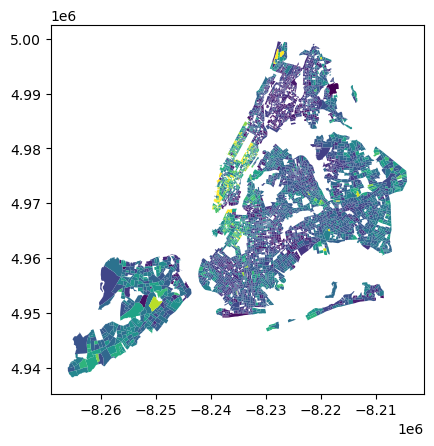

In [70]:
#I plot the median household income
#there's a lot of missing values in the median household income data
cens.plot("median_hh_income")

In [71]:
# Instead of filling the missing with mean, I fill them with the closest neighbor's value
from shapely.geometry import Point
from scipy.spatial import cKDTree

# Identify missing values
missing_cens = cens[cens['median_hh_income'].isnull()]

# Filter out polygons with missing median_hh_income values
cens_with_values = cens.dropna(subset=['median_hh_income'])

# Create a KDTree for efficient nearest neighbor search
tree = cKDTree(cens_with_values.geometry.apply(lambda x: (x.centroid.x, x.centroid.y)).tolist())

# Function to find closest polygon with a value
def find_closest_polygon(point, tree, cens_with_values):
    _, idx = tree.query((point.x, point.y))
    return cens_with_values.iloc[idx]

# Iterate over missing polygons and fill missing values
for index, row in missing_cens.iterrows():
    closest_cens = find_closest_polygon(row.geometry.centroid, tree, cens_with_values)
    # Assuming '_median_hh_income' is the column you want to fill
    filled_value = closest_cens['median_hh_income']
    cens.at[index, 'median_hh_income'] = filled_value

<Axes: >

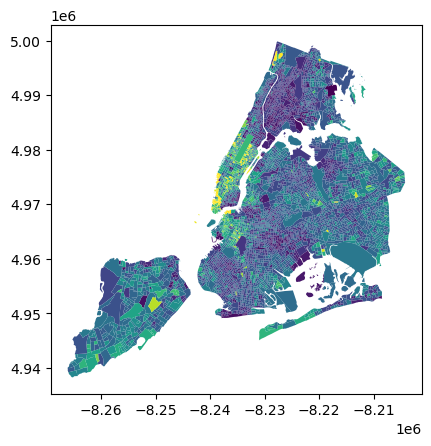

In [72]:
cens.plot("median_hh_income")

In [73]:
#I'm going to add the census data into the taxi zone data
taxi_zones.to_crs(epsg=3857, inplace=True)

#set centroid as geometry for taxi zones and perform join with census data
taxi_zones["geometry"] = taxi_zones["geometry"].centroid

joined = gpd.sjoin(taxi_zones, cens, how='left', op='within')

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\shapely\constructive.py:288: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)
c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [74]:
missing_cens = cens[cens['median_hh_income'].isna()]

In [75]:
#there are three locations that were not matched to the census data
#governor's island/ellis island, Newark Airport, and City Island
#after examining these locations using: 

#joined[joined['index_right'].isna()].explore()

#I decided to manually overwrite information for City Island (centorid falls in water), and use the mean values for the other two locations
joined[joined['index_right'].isna()]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,GISJOIN,total_pop,total_pop_hispanic,total_pop_white,total_pop_black,total_pop_native,total_pop_asian,total_pop_pacific,total_pop_other,median_hh_income,COUNTY
0,1,0.116357,0.000782,Newark Airport,1,EWR,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,260,0.133514,0.000422,Woodside,260,Queens,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
#selectively replace for city_island
city_island = cens[cens["GISJOIN"] == "G36000500516013"]

#the index for city island is 46
for col in cens.columns:
  joined.loc[45, col] = city_island[col].values[0]

selected_columns = ['column1', 'column2', 'column3']

In [77]:
#fill with median for other missing vals
fill_cols = ['total_pop', 'total_pop_hispanic', 'total_pop_white',
       'total_pop_black', 'total_pop_native', 'total_pop_asian',
       'total_pop_pacific', 'total_pop_other', 'median_hh_income']

joined[fill_cols] = joined[fill_cols].fillna(joined[fill_cols].median())

In [78]:
#now I can see that the rows that used to not have census data have them now
#
joined[joined['index_right'].isna()]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,index_right,GISJOIN,total_pop,total_pop_hispanic,total_pop_white,total_pop_black,total_pop_native,total_pop_asian,total_pop_pacific,total_pop_other,median_hh_income,COUNTY
0,1,0.116357,0.000782,Newark Airport,1,EWR,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
259,260,0.133514,0.000422,Woodside,260,Queens,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,POINT EMPTY,NaN,NaN,1251.0,311.0,785.0,43.0,0.0,70.0,0.0,353.0,150227.0,NaN


In [79]:
#the original dataset is too big, so I try to randomly sample 3000 trips
taxi_data_small = taxi_data.sample(n=3000, random_state=42)

In [80]:
taxi_data_small_census = pd.merge(taxi_data_small, joined, left_on='DOLocationID', right_on='OBJECTID', how='left')

In [81]:
taxi_data_small_census.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_time',
       'dropoff_time', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone',
       'LocationID', 'borough', 'geometry', 'index_right', 'GISJOIN',
       'total_pop', 'total_pop_hispanic', 'total_pop_white', 'total_pop_black',
       'total_pop_native', 'total_pop_asian', 'total_pop_pacific',
       'total_pop_other', 'median_hh_income', 'COUNTY'],
      dtype='object')

In [82]:
data_cols = ['VendorID', 'trip_distance', 'DOLocationID', 'payment_type', 'fare_amount','extra','mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge','total_amount', 'total_pop', 'total_pop_hispanic','total_pop_white', 'total_pop_black', 'total_pop_native','total_pop_asian', 'total_pop_pacific', 'total_pop_other','median_hh_income']

X = taxi_data_small_census[data_cols]
y = taxi_data_small_census['PULocationID']

In [83]:
X.isna().sum()

VendorID                  0
trip_distance             0
DOLocationID              0
payment_type              0
fare_amount               0
extra                     0
mta_tax                   0
tip_amount                0
tolls_amount              0
improvement_surcharge     0
total_amount              0
total_pop                24
total_pop_hispanic       24
total_pop_white          24
total_pop_black          24
total_pop_native         24
total_pop_asian          24
total_pop_pacific        24
total_pop_other          24
median_hh_income         24
dtype: int64

In [84]:
#There is missing data (zone 264 and 265 are out of NYC or N/A), so need to replace these with mean
fill_cols = ['total_pop', 'total_pop_hispanic', 'total_pop_white',
       'total_pop_black', 'total_pop_native', 'total_pop_asian',
       'total_pop_pacific', 'total_pop_other', 'median_hh_income']

X[fill_cols] = X[fill_cols].fillna(X[fill_cols].median())

C:\Users\desai\AppData\Local\Temp\ipykernel_24108\1541919609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[fill_cols] = X[fill_cols].fillna(X[fill_cols].median())


In [85]:
#now train model
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.14166666666666666


In [86]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df_importance = pd.DataFrame({"col name":data_cols, "importance":importances})

df_importance.sort_values(by="importance", ascending=False)

,col name,importance
1,trip_distance,0.231055
2,DOLocationID,0.203035
10,total_amount,0.167344
4,fare_amount,0.143690
7,tip_amount,0.128111
5,extra,0.071368
3,payment_type,0.024693
0,VendorID,0.019002
8,tolls_amount,0.008771
6,mta_tax,0.002126


Based on this feature importance table, it seems like the census data was not too important. However, the model accuracy did improve by around 2% as compared to those without census data.